<a href="https://colab.research.google.com/github/mateusz-wozny/SUS/blob/main/Raport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Raport ze studium przypadku
## Mateusz Woźny 140859

## Import bibliotek

In [ ]:
!pip install lime

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from matplotlib import cm
from sklearn.model_selection import  train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, plot_tree
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from scipy.stats import t
from dtreeviz.trees import *
from IPython.core.display import display, HTML
import lime
import lime.lime_tabular
import re

## Wczytanie danych

In [ ]:
df = pd.read_csv("ozon_data.csv")
df = df.drop(columns=df.columns[0])
X = df.iloc[:, 1:]
y = df["O3"]


#Opis danych

Zbiór danych został opublikowany przez Leo Breimana w 1985 roku, który był konsultantem w projekcie dotyczącym badania czynników wpływających na stężenie ozonu w powietrzu. Zestaw danych posiada tylko zmienne w skali ilorazowej, przez co był szeroko stosowany przez badaczy do zaprezentowania metod regresji wielu zmiennych (np. przez Friedmana). Zestaw danych znajduje się między innymi w pakiecie earth w programie R.

Badanie zostało wykonane w 1976 roku i dotyczy Los Angeles w stanie Kalifornia. Zmienną objaśnianą jest maksymalne średnie stężenie ozonu danego dnia. Średnia była liczona co godzinę.

Zmiennymi objaśniającymi są:
* vh [m] - wysokość na której ciśnienie wynosi 500 milibarów, 
* wind [m/h] - prędkość wiatru,
* humidity [%] - stopień wilgotności powietrza,
* temp [F] - temperatura powietrza,
* ibh [stopy] -  wysokość na której zachodzi inwersja temperatury, czyli zjawisko polegające na tym, że temperatura zamiast maleć, rośnie wraz z wysokością,
* dpg [mm Hg] - gradient ciśnienia,
* ibt [F] - temperatura inwersji,
* vis [mile] - widoczność,
* doy [-] - dzień w roku.




## Analiza zbioru danych

### Wykresy punktowe

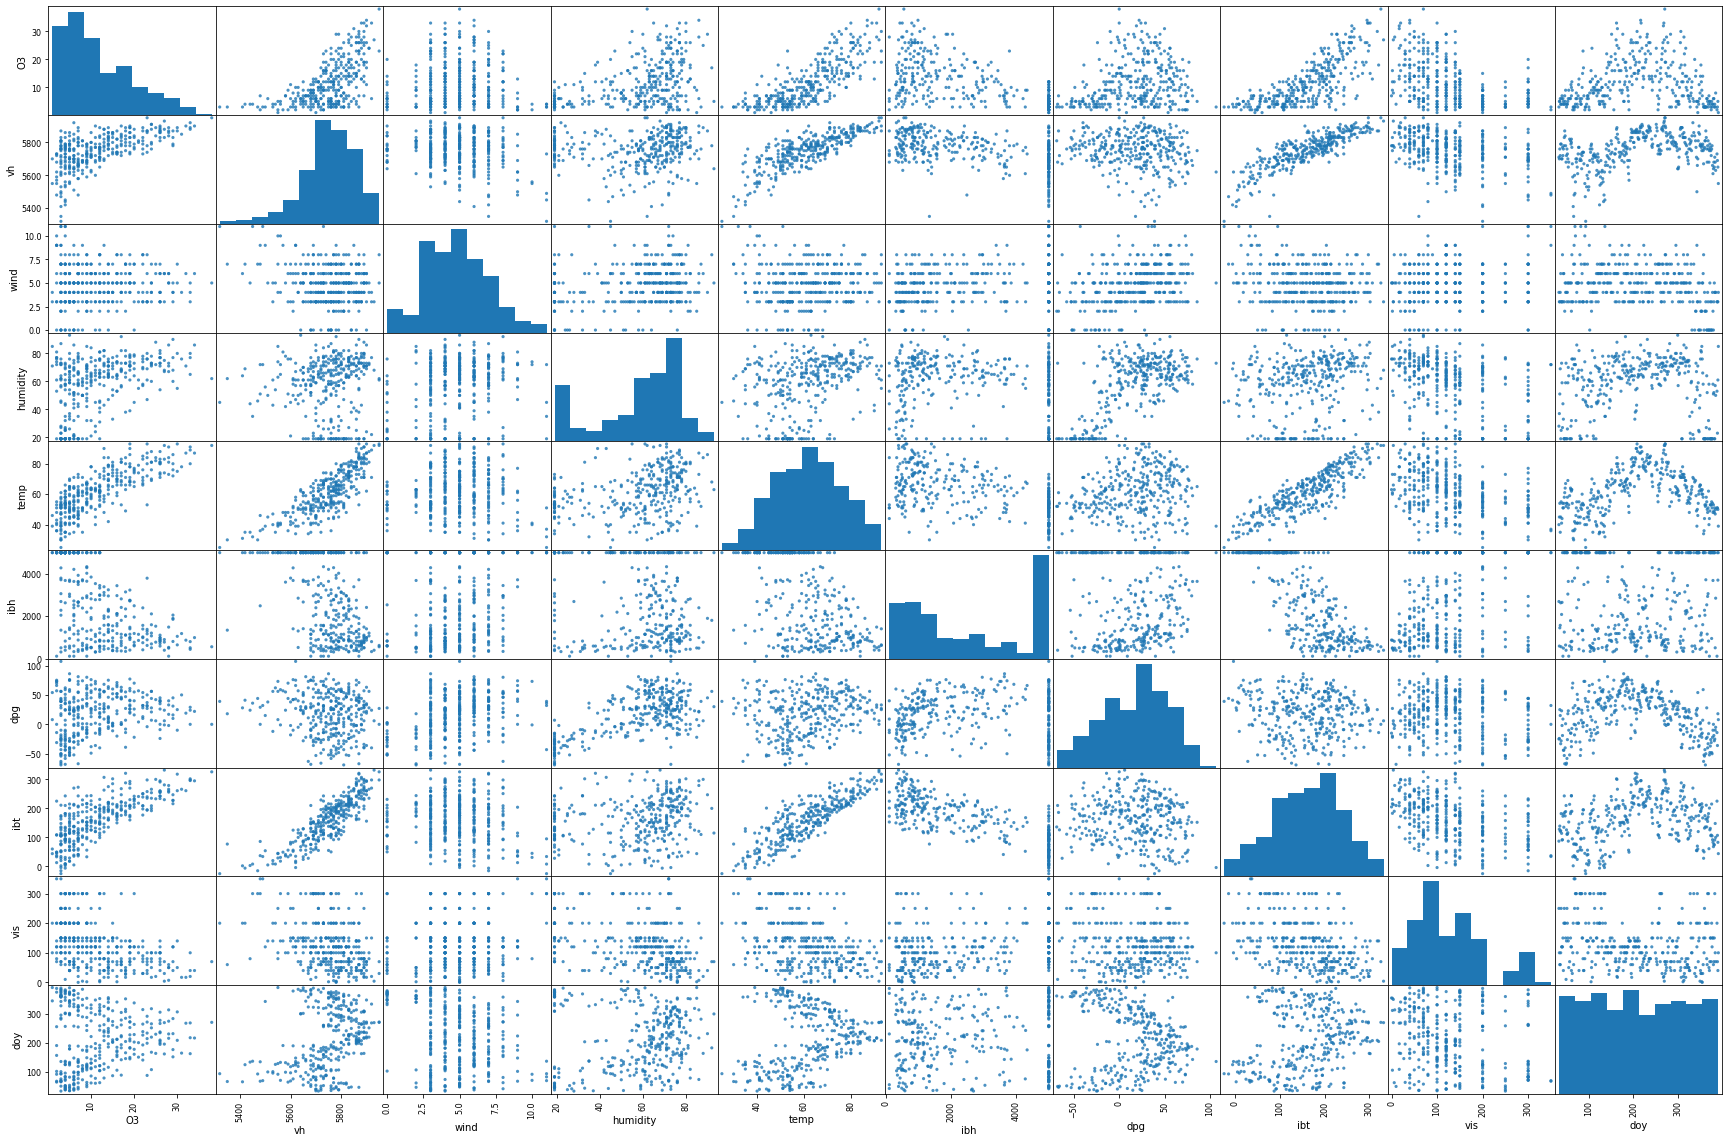

In [ ]:
pd.plotting.scatter_matrix(df, figsize=(30,20), marker='o', s=10, alpha=.8)
plt.show()

Na podstawie powyższych wykresów punktowych, że w przypadku atrybutu wind jego wartości są dyskretne, ponieważ dla każdego wykresu, gdzie występuje atrybut wind jego kolejne wartości pojawiają się co pewien krok. W większości przypadków ciężko zaobserwować jakieś zależności pomiędzy atrybutami, jednak na przykład w przypadku takiej pary atrybutów jak vh-ibt, temp-ibt czy O3-temp można zauważyć pewną korelację między wartościami atrybutów.

### Wykresy pudełkowe

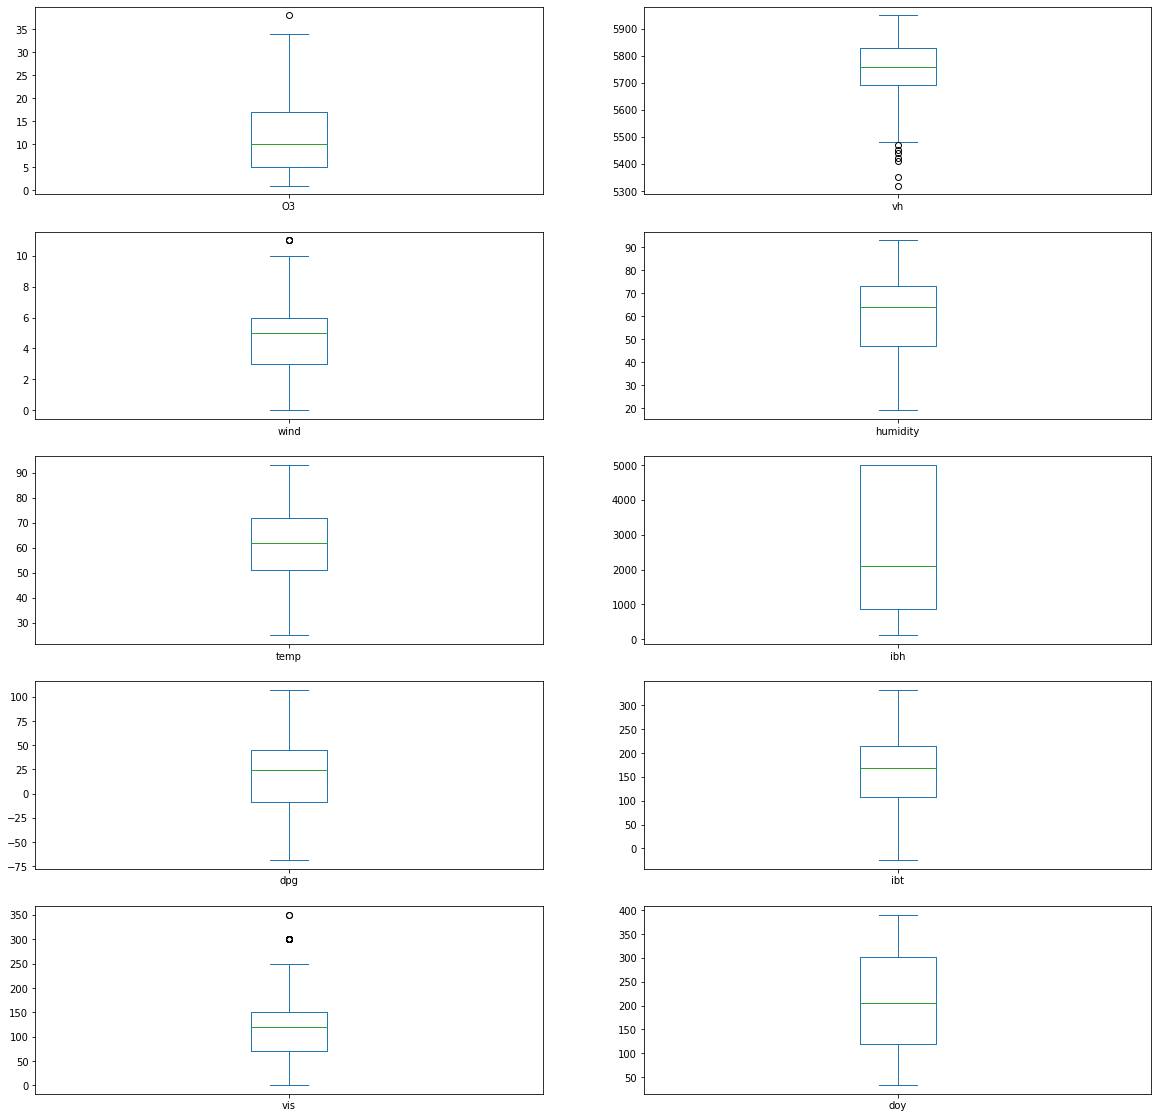

In [ ]:
df.plot(kind='box', subplots=True, figsize=(20, 20), layout = (5, 2))
plt.show()

Dla wykresów pudełkowych możliwe jest zauważenie rozłożenia wartości atrybutów. W przypadku atrybutu doy jego wykres jest praktycznie idealnie rozłożonym pudełkiem, symetrycznym względem mediany. Dla atrybutu vh pojawia się kilka wartości leżących poniżej pierwszego kwartyla. Dla większości atrybutów ich rozkłady nie posiadają wiele wartości odstających, różnią się one głównie kształtem pudełka i zakresem przyjmowanych wartości.

### Przykłady ze zbioru danych

In [ ]:
print(f"Zima \n{df[df['doy']==33]}\n")
print(f"Lato \n{df[df['doy']==165]}\n")

Zima 
   O3    vh  wind  humidity  temp   ibh  dpg  ibt  vis  doy
0   3  5710     4        28    40  2693  -25   87  250   33

Lato 
     O3    vh  wind  humidity  temp   ibh  dpg  ibt  vis  doy
126  18  5820     6        63    80  1991   47  209   40  165



Wybrane zostały dwa przypadki z różnych części roku.
Pomiary uzyskane na początku roku dotyczą zimy. Obserwujemy stosunkowo niską temperaturę, jest to ok. 4 stopni Celsjusza, natomiast latem jest to ok. 26.6 stopni Celsjusza.
Można zauważyć, że wyższa temperatura współwystępuje z wyższym stężeniem ozonu. Co więcej, wraz ze wzrostem temperatury powietrza rośnie temperatura inwersji. Gdy inwersja zachodzi na niższej wysokości, to jej temperatura jest wyższa. Aby potwierdzieć te obserwacje, dokonano w następnym kroku analizy korelacji.


### Macierz korelacji

In [ ]:
df.corr().style.background_gradient(cmap='coolwarm')

,O3,vh,wind,humidity,temp,ibh,dpg,ibt,vis,doy
O3,1.000000,0.607344,0.002471,0.449224,0.780703,-0.589534,0.214046,0.745578,-0.440989,0.067634
vh,0.607344,1.000000,-0.225821,0.074485,0.808059,-0.504835,-0.148071,0.852021,-0.360080,0.337879
wind,0.002471,-0.225821,1.000000,0.222868,-0.005886,0.196746,0.341951,-0.159814,0.127702,-0.251125
humidity,0.449224,0.074485,0.222868,1.000000,0.340474,-0.242328,0.647789,0.203648,-0.401008,0.041261
temp,0.780703,0.808059,-0.005886,0.340474,1.000000,-0.532645,0.189242,0.864787,-0.387721,0.239335
ibh,-0.589534,-0.504835,0.196746,-0.242328,-0.532645,1.000000,0.037078,-0.776933,0.386686,0.042603
dpg,0.214046,-0.148071,0.341951,0.647789,0.189242,0.037078,1.000000,-0.095060,-0.125855,-0.152742
ibt,0.745578,0.852021,-0.159814,0.203648,0.864787,-0.776933,-0.095060,1.000000,-0.422372,0.220058
vis,-0.440989,-0.360080,0.127702,-0.401008,-0.387721,0.386686,-0.125855,-0.422372,1.000000,-0.217701
doy,0.067634,0.337879,-0.251125,0.041261,0.239335,0.042603,-0.152742,0.220058,-0.217701,1.000000


Powyższa macierz korelacji potwierdza fakty zaobserwowane podczas analizy wybranych przypadków i wykresów punktowych tzn., że atrybuty O3 i temp są ze sobą dość mocno skorelowane, to samo można zauważyć w przypadku vh-temp i vh-ibt. Jednak największą korelacją dodatnią charakteryzuje się para temp-ibt, co może wynikać z faktu, że oba te atrybuty są związane z temperaturą. 

### Przedstawienie danych w przestrzeni 2D za pomocą transformacji PCA

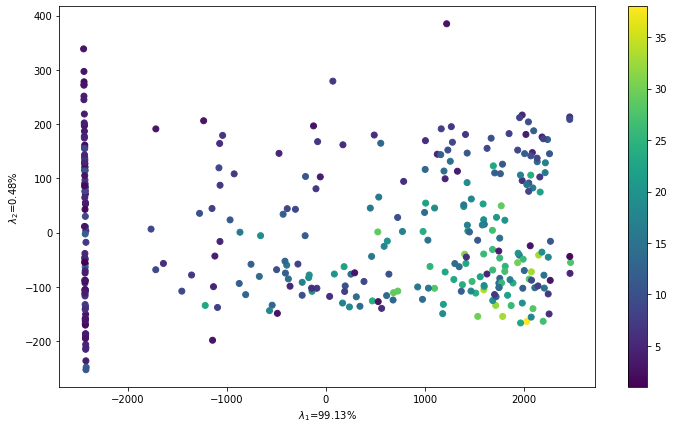

In [ ]:
pca = PCA(n_components = 2)

X_reduced = pca.fit_transform(X)

plt.figure(figsize = (12, 7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c = y)
plt.colorbar()
plt.xlabel(f"$\lambda_1$={pca.explained_variance_ratio_[0]:.2%}")
plt.ylabel(f"$\lambda_2$={pca.explained_variance_ratio_[1]:.2%}")
plt.show()

Po transformacji PCA można zauważyć jedną bardzo ciekawą rzecz, mianowicie pierwsza składowa główna wyjaśnia ponad 99% całkowitej wariancji, co nie jest zbyt częstym zjawiskiem. Interesujące jest również ułożenie niektórych obserwacji w pionowej linii (lewa strona wykresu). Na podstawie koloru punktów widoczne jest, że są to przykłady o zbliżonej wartości stężenia ozonu, głównie są to wartości dość niskie (poniżej 5).

## Wykorzystanie 3 różnych modeli do predykcji stężenia ozonu

Sprawdzone zostały trzy modele: XGBoost, drzewo regresyjne oraz głęboka sieć neuronowa. W przypadku tych dwóch pierwszych została wykorzystana metoda GridSearch w celu znalezienia optymalnych parametrów. Użyta została również 10-krotna walidacja dzięki czemu w wyniku zwrócone zostały wartości średnie oraz odchylenia standardowe. W celu sprawdzenia istotności różnic w wynikach uzyskiwanych dla poszczególnych parametrów wyznaczane zostały testy t-Studenta.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
        shuffle=True, random_state=42)


#### Funkcje pomocnicze

In [ ]:
def convert_dict(d: dict):
  s = ""
  items = d.items()
  for i,j in enumerate(items):
    s+=f"{j[0]}={j[1]}"
    if i<len(items)-1:
      s+=", "
  return s

def t_student_test(mean1, std1, mean2, std2, n, alpha = 0.05):
  results = []
  for m,s in zip(mean2, std2):
    sed = np.sqrt(std1**2/n + s**2/n)
    
    t_stat = abs(mean1 - m) / sed
    cv = t.ppf(1.0 - alpha, 2*n - 2)
    results.append(t_stat>cv)

  return results


def find_name(x):
  pattern = re.compile(r'[a-zA-Z]')
  return "".join(pattern.findall(x))

### XGBoost

Jako pierwszy model sprawdzony został XGBRegressor. W celu znalezienia jak najlepszych parametrów dla modelu wykorzystana została metoda GridSearchCV. Jej użycie pozwala również na wykonywanie walidacji krzyżowej, dzięki czemu uzyskane rezultaty są uśrednionymi wartościami. Na tej podstawie dla danej miary jakości istnieje możliwość odwołania się do jej wartości średniej oraz odchylenia standardowego.

In [ ]:
gsc = GridSearchCV(
            estimator = XGBRegressor(),
            param_grid = {"max_depth": [1, 2, 3, 4, 5],
                        "gamma":[0.1, 0.2, 0.3, 0.5]},
              cv = 10, scoring='neg_mean_squared_error', verbose = False)

gsc.fit(X_train, y_train)

In [ ]:
df = pd.DataFrame()
df["params"] = gsc.cv_results_["params"]
df["params"] = df["params"].apply(convert_dict)
df["mean_test_score"] = -gsc.cv_results_["mean_test_score"]
df["std_test_score"] = gsc.cv_results_["std_test_score"]
df.sort_values(by = "mean_test_score", inplace = True, ignore_index = True)
df["Reject null hypotesis"] = t_student_test(df["mean_test_score"][0], df["std_test_score"][0],
                                      df["mean_test_score"], df["std_test_score"], X_train.shape[0])
df

,params,mean_test_score,std_test_score,Reject null hypotesis
0,"gamma=0.1, max_depth=2",15.288647,4.269603,False
1,"gamma=0.1, max_depth=3",15.371683,4.343128,False
2,"gamma=0.2, max_depth=2",15.376154,4.406106,False
3,"gamma=0.5, max_depth=2",15.380905,4.401424,False
4,"gamma=0.3, max_depth=2",15.381092,4.401199,False
5,"gamma=0.3, max_depth=3",15.387602,4.317457,False
6,"gamma=0.5, max_depth=3",15.446089,4.329109,False
7,"gamma=0.2, max_depth=3",15.447898,4.285215,False
8,"gamma=0.5, max_depth=4",15.875443,4.489686,False
9,"gamma=0.1, max_depth=4",15.999414,4.346277,True


Dla każdego przypadku porównana została jego średnia wartość MSE z wartością dla najlepszego estymatora w celu sprawdzenia istotności różnic. Na podstawie powyższej tabeli można zauważyć, że kolejne 8 najlepszych (względem średniego MSE) kombinacji parametrów  $\gamma$ i max_depth nie są istotnie różne od najlepszego estymatora, czyli różnice w działaniu algorytmu nie są zbyt duże dla nich.

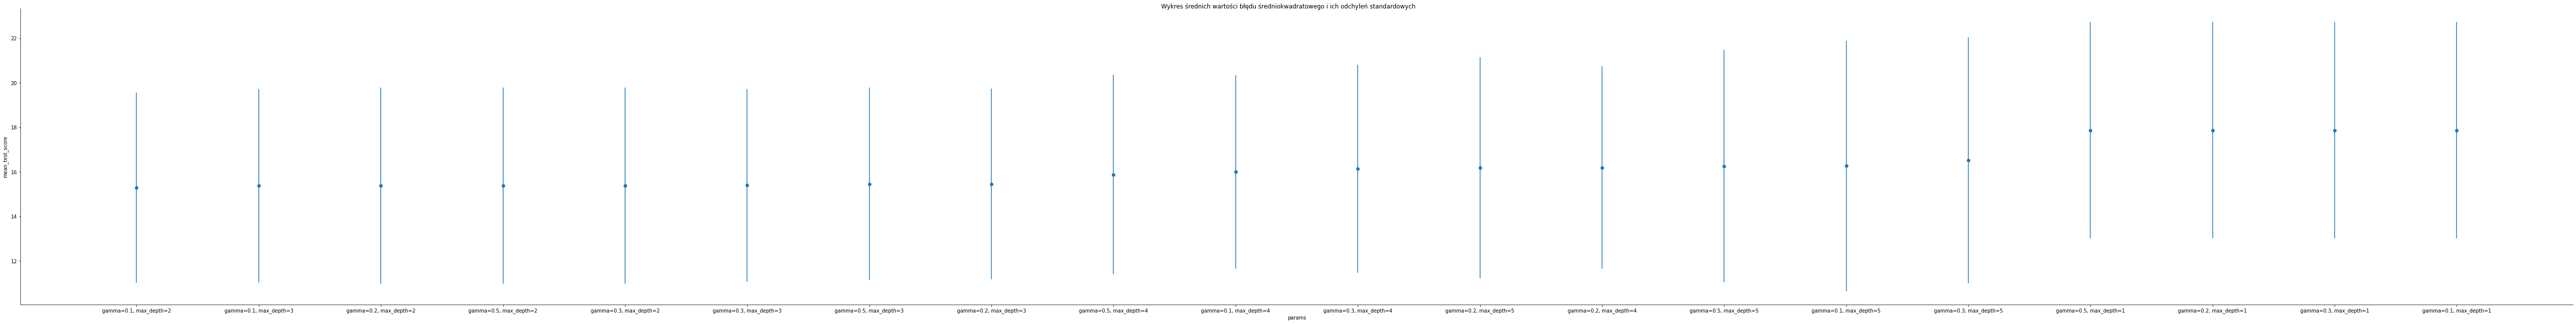

In [ ]:
g = sns.FacetGrid(df, height = 9, aspect = 8)
g.map(plt.errorbar, "params", "mean_test_score", yerr = df["std_test_score"], fmt = 'o')
g.fig.suptitle("Wykres średnich wartości błędu średniokwadratowego i ich odchyleń standardowych", y=1)
g.fig.show()

Powyższy wykres dobrze obrazuje fakt zaobserwowany na podstawie tabeli i testu t-Studenta, czyli że nie ma istotnej różnicy pomiędzy estymatorami 0-8.

In [ ]:
print(f"MSE dla najlepszego estymatora {mean_squared_error(y_test, gsc.best_estimator_.predict(X_test)):.2f}")

MSE dla najlepszego estymatora 18.22


Uzyskany model został sprawdzony na zbiorze testowym w celu odpowiedniej weryfikacji jego jakości, sprawdzanie na samym zbiorze treningowym nie przynosi zbyt wielu informacji.

#### Wizualizacja wyindukowanej wiedzy przez XGBoost

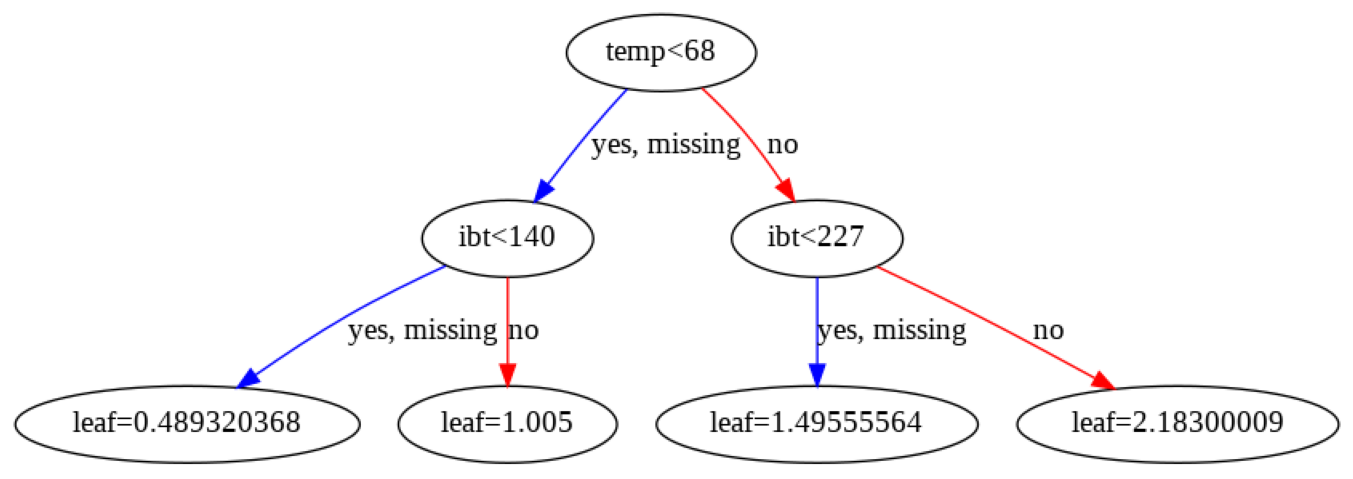

In [ ]:
plt.rcParams["figure.figsize"] = (24, 12)
plot_tree(gsc.best_estimator_)
plt.show()

Dzięki zastosowaniu biblioteki XGBoost możliwe jest zwizualizowanie wiedzy wyindukowanej przez model. Na tej podstawie możemy zauważyć, że najbardziej istotnymi cechami dla algorytmu są temp oraz ibt, czyli atrybuty, które są mocno ze sobą skorelowane (co zostało wcześniej przedstawione w macierzy korelacji).

### Drzewo regresyjne

Jako drugi rodzaj modelu sprawdzone zostały drzewa regresyjne, ponownie wykorzystana została metoda GridSearchCV w celu wyznaczenia jak najlepszych parametrów.

In [ ]:
gsc2 = GridSearchCV(DecisionTreeRegressor(), 
                    param_grid = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50]}
                    ,cv=10, scoring='neg_mean_squared_error')
gsc2.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       15, 20, 30, 40, 50]},
             scoring='neg_mean_squared_error')

In [ ]:
df2 = pd.DataFrame()
df2["params"] = gsc2.cv_results_["params"]
df2["params"] = df2["params"].apply(convert_dict)
df2["mean_test_score"] = -gsc2.cv_results_["mean_test_score"]
df2["std_test_score"] = gsc2.cv_results_["std_test_score"]
df2.sort_values(by="mean_test_score", inplace = True, ignore_index = True)
df2["Reject null hypotesis"] = t_student_test(df2["mean_test_score"][0], df2["std_test_score"][0],
                                      df2["mean_test_score"], df2["std_test_score"], X_train.shape[0])
df2

,params,mean_test_score,std_test_score,Reject null hypotesis
0,max_depth=3,21.275225,5.315720,False
1,max_depth=5,22.641032,7.298112,True
2,max_depth=4,23.042327,8.222323,True
3,max_depth=2,25.357873,8.321510,True
4,max_depth=6,26.131508,6.725784,True
5,max_depth=9,26.645465,4.799581,True
6,max_depth=7,26.977715,9.117317,True
7,max_depth=8,27.064752,8.043982,True
8,max_depth=50,27.069516,4.151790,True
9,max_depth=30,27.321225,6.098259,True


Dla drzewa regresyjnego jedynym modyfikowanym parametrem była jego głębokość. Powyższa tabela i wyniki testu t-Studenta pokazują, że najlepszy estymator był faktycznie najlepszy i pozostałe estymatory mają istotnie gorszą średnią wartość MSE w porównaniu do niego. W przypadku XGBRegressor odchylenia standardowe były do siebie zbliżone, w tym przypadku widoczne jest, że dla niektórych głębokości wartość odchylenia standardowego jest zdecydowanie większa od pozostałych (na przykład max_depth=2 i $σ=8.32$).

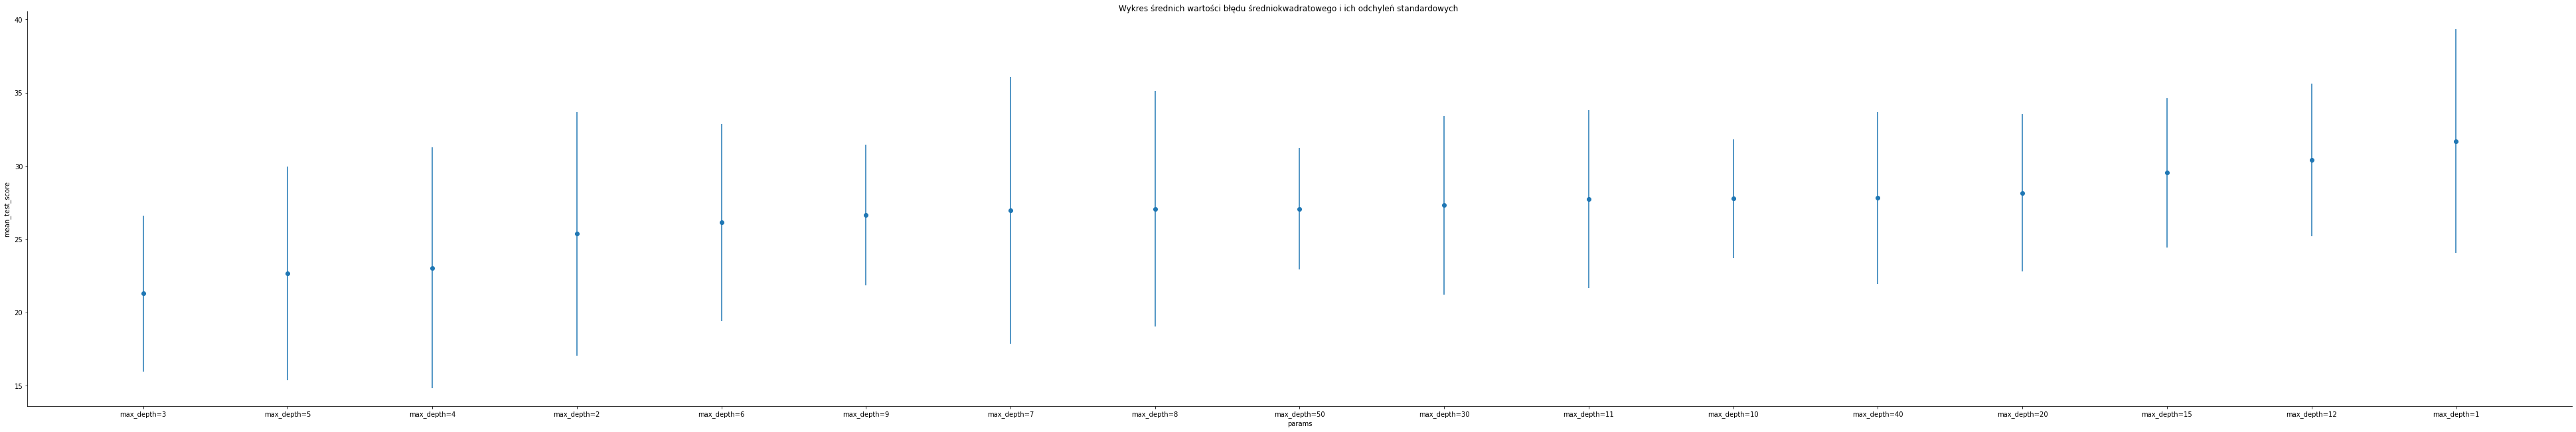

In [ ]:
g = sns.FacetGrid(df2, height = 9, aspect = 6)
g.map(plt.errorbar, "params", "mean_test_score", yerr = df2["std_test_score"], fmt = 'o')
g.fig.suptitle("Wykres średnich wartości błędu średniokwadratowego i ich odchyleń standardowych", y=1)
g.fig.show()

Powyższy wykres dobrze obrazuje przewagę najlepszego estymatora nad pozostałymi, jego średnia jest najniższa, również odchylenie standardowe nie jest zbyt duże.

In [ ]:
print(f"MSE dla najlepszego estymatora {mean_squared_error(y_test, gsc2.best_estimator_.predict(X_test)):.2f}")

MSE dla najlepszego estymatora 24.13


Po sprawdzeniu najlepszego estymatora uzyskanego z GridSearchCV dla drzewa regresji zauważalne jest, że osiąga ono gorszy wynik na zbiorze testowymi niż model XGBRegressor.

#### Wizualizacja wyindukowanej wiedzy przez drzewo regresyjne

In [ ]:
!pip install dtreeviz
!apt-get install graphviz

In [ ]:
viz = dtreeviz(gsc2.best_estimator_,
               X,
               y, 
               feature_names = X.columns,
               target_name = "ozone") 

display(HTML(viz.svg()))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


Podobnie jak w przypadku XBGRegressor dla drzew regresji również istnieje możliwość wizualizacji modelu. Warto zauważyć, że atrybuty które były najbardziej istotne dla XGBRegressor (temp i ibt) również w przypadku drzewa regresji są na jego szczycie.

### Sieć neuronowa

Jako ostatni model sprawdzona została sieć neuronowa. Sieci neuronowe są obecnie bardzo popularne, głównie przez ich zastosowanie między innymi w klasyfikacji obrazów czy ich segmentacji.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(9,)))
model.add(tf.keras.layers.Dense(256, activation = tf.nn.silu))
model.add(tf.keras.layers.Dense(128, activation = tf.nn.silu))
model.add(tf.keras.layers.Dense(64, activation = tf.nn.silu))
model.add(tf.keras.layers.Dense(32, activation = tf.nn.silu))
model.add(tf.keras.layers.Dense(16, activation = tf.nn.silu))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer = 'adam',
               loss = 'mean_squared_error',
               metrics = ['mean_squared_error'])
history = model.fit(X_train, y_train, epochs = 100, verbose = False)

In [ ]:
print(f"MSE dla sieci neuronowej {mean_squared_error(y_test, model.predict(X_test)):.2f}")

MSE dla sieci neuronowej 35.68


Wartość MSE osiągana przez sieć neuronową jest zdecydowanie najgorsza spośród wszystkich sprawdzanych modeli.

#### Interpretacja decyzji modelu za pomocą LIME

W przypadku sieci neuronowej dokonanie wizualizacji wiedzy wyindukowanej przez model nie jest zbyt proste. W celu znalezienia istotności cech dla modelu wykorzystany zostanie algorytm LIME. Ze względu na małą liczebność zbioru testowego dla każdego przykładu uruchomiony zostanie algorytm i dla każdego atrybutu pobrana zostanie jego waga (jej bezwzględna wartość). Następnie wszystkie wartości zostaną zgrupowane i zagregowane poprzez zsumowanie.

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X), mode='regression', feature_names = X.columns)

importance = []
for i in range(X_test.shape[0]):
  instance_explainer = explainer.explain_instance(
	  np.array(X_test)[i, :], model.predict, num_features=len(X.columns))
  importance.extend(list(map(lambda x: (find_name(x[0]), abs(x[1])), instance_explainer.as_list())))


df = pd.DataFrame(importance, columns=["name", "importance"]).groupby(by="name").sum().sort_values(by="importance", ascending=False)

In [ ]:
df

,importance
name,
ibh,419.146309
ibt,217.454222
dpg,143.249648
vis,94.893434
vh,17.528699
humidity,12.920893
doy,11.939687
temp,8.851772
wind,7.792609


Powyższa tabela przedstawia sumę wag (ich wartości bezwględnych) dla poszczególnych atrybutów. Widoczne jest, że atrybut ibh posiada zdecydowanie najwięszką wartość. Porównując to z wiedzą wyindukowaną przez XGBRegressor i drzewo regresyjne jest to dość dziwne. Natomiast kolejny atrybut (ibt) również występował jako istotny w dwóch poprzednich modelach. Jednak atrybut temp posiada bardzo małą wartość w porównaniu z pozostałymi atrybutami. Dla XGBRegressor i drzewa regresyjnego był on bowiem najważniejszym atrybutem decyzyjnych.

## Sprawdzenie czy zmiana jednostki temperatury będzie miała znaczący wpływ na działanie modelu (XGBRegressor)

W poniższej sekcji sprawdzone zostanie czy zmiana jednostki dla atrybutów temp i ibt (ze stopni Fahrenheita na Celsjusza) będzie miała wpływ na działanie modelu. Wzór pozwalający na zamianę jednostek:

$$C = \frac{5}{9} \cdot (F-32)$$

In [ ]:
from copy import deepcopy

X_temp = deepcopy(X)
X_temp["temp"] = 5/9*(X_temp["temp"]-32)
X_temp["ibt"] = 5/9*(X_temp["ibt"]-32)

X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, 
        shuffle=True, random_state=42)

In [ ]:
gsc = GridSearchCV(
            estimator = XGBRegressor(),
            param_grid = {"max_depth": [1, 2, 3, 4, 5],
                        "gamma":[0.1, 0.2, 0.3, 0.5]},
              cv = 10, scoring='neg_mean_squared_error', verbose = False)

gsc.fit(X_train, y_train)

In [ ]:
df = pd.DataFrame()
df["params"] = gsc.cv_results_["params"]
df["params"] = df["params"].apply(convert_dict)
df["mean_test_score"] = -gsc.cv_results_["mean_test_score"]
df["std_test_score"] = gsc.cv_results_["std_test_score"]
df.sort_values(by = "mean_test_score", inplace = True, ignore_index = True)
df["Reject null hypotesis"] = t_student_test(df["mean_test_score"][0], df["std_test_score"][0],
                                      df["mean_test_score"], df["std_test_score"], X_train.shape[0])
df

,params,mean_test_score,std_test_score,Reject null hypotesis
0,"gamma=0.1, max_depth=2",15.318475,4.257660,False
1,"gamma=0.1, max_depth=3",15.393388,4.337009,False
2,"gamma=0.2, max_depth=2",15.405982,4.393940,False
3,"gamma=0.5, max_depth=2",15.410733,4.389213,False
4,"gamma=0.3, max_depth=2",15.410920,4.388986,False
5,"gamma=0.3, max_depth=3",15.412160,4.312088,False
6,"gamma=0.5, max_depth=3",15.466946,4.322772,False
7,"gamma=0.2, max_depth=3",15.472322,4.279272,False
8,"gamma=0.5, max_depth=4",15.885522,4.487041,False
9,"gamma=0.1, max_depth=4",16.008761,4.345689,True


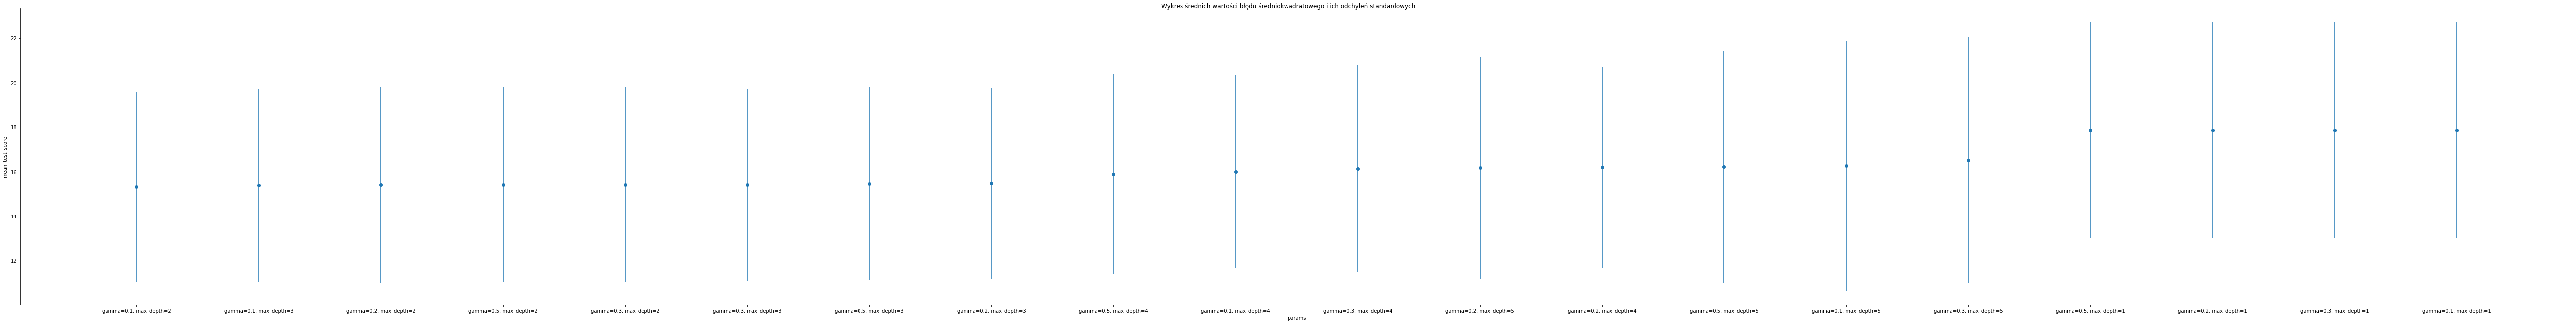

In [ ]:
g = sns.FacetGrid(df, height = 9, aspect = 8)
g.map(plt.errorbar, "params", "mean_test_score", yerr = df["std_test_score"], fmt = 'o')
g.fig.suptitle("Wykres średnich wartości błędu średniokwadratowego i ich odchyleń standardowych", y=1)
g.fig.show()

In [ ]:
print(f"MSE dla najlepszego estymatora {mean_squared_error(y_test, gsc.best_estimator_.predict(X_test)):.2f}")

MSE dla najlepszego estymatora 18.22


Zamiana jednostek nie wpłynęła na zmianę dopasowania modelu. Błąd MSE wynosił 18,22 zarówno w przypadku stopni Fahrenheita, jak i stopni Celsjusza.